In [1]:
import pandas as pd
import numpy as np
#
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.cm as cm
from matplotlib.pyplot import figure
import seaborn as sns
#
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from scipy.stats import boxcox, anderson
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_samples, silhouette_score
#
#from sklearn.decomposition import PCA

In [2]:
np.random.seed(42)

In [3]:
def Chart3D (cat_column):



    fig = plt.figure(figsize=(12, 10))
    ax = fig.add_subplot(projection='3d')


    for s in df[cat_column].unique():
        ax.scatter(df[df[cat_column]==s]['RECENCY'], df[df[cat_column]==s]['FREQUENCY'], df[df[cat_column]==s]['MONETARY'],  label=f'{s}')
    ax.set_xlabel('RECENCY')
    ax.set_ylabel('FREQUENCY')
    ax.set_zlabel('MONETARY')
    ax.legend(loc='upper right')

    plt.show()
#
def PieChart(cat_column):
    # Set Seaborn style
    sns.set(style="whitegrid")

    # Prepare data
    segment_counts = df[cat_column].value_counts()

    # Plot
    fig, ax = plt.subplots()
    ax.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90)
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

    plt.title('Customer Segmentation')
    plt.show()
#
def SummaryStats(cat_column):
    
    summary_stats_df = pd.DataFrame()

    for segment in df[cat_column].unique():
        segment_data = df[df[cat_column] == segment]

        # Summary for numerical features
        num_summary = segment_data[numerical_features].agg(['mean', 'std', 'min', 'max', 'count']).unstack()

        # Adding the segment summary to the overall summary
        summary_stats_df = pd.concat([summary_stats_df, num_summary], axis=1)

    # Naming the columns after the segments
    summary_stats_df.columns = [f"Segment_{seg}" for seg in df[cat_column].unique()]
    
    return summary_stats_df

In [4]:
df = pd.read_csv('./rfm_data.csv')
df.head()

,O_CUSTKEY,RECENCY,FREQUENCY,MONETARY,R,F,M,RFM,RFM_SEGMENT
0,42239,55,1,65877.82,3,1,1,5,Need Attention
1,146873,22,2,146251.72,1,1,1,3,Need Attention
2,15110,43,4,170052.01,2,1,1,4,Need Attention
3,10061,178,4,183773.21,5,1,1,7,Potential
4,43214,173,2,184758.23,5,1,1,7,Potential


In [5]:
len(df)

65263

In [6]:
df.columns

Index(['O_CUSTKEY', 'RECENCY', 'FREQUENCY', 'MONETARY', 'R', 'F', 'M', 'RFM',
       'RFM_SEGMENT'],
      dtype='object')

In [7]:
unique_id=['O_CUSTKEY']
numerical_features=['RECENCY', 'FREQUENCY', 'MONETARY']

## RFM Segments (created using SQL transformation)

In [8]:
df['RFM_SEGMENT'].unique()

array(['Need Attention', 'Potential', 'Loyal', 'Champion'], dtype=object)

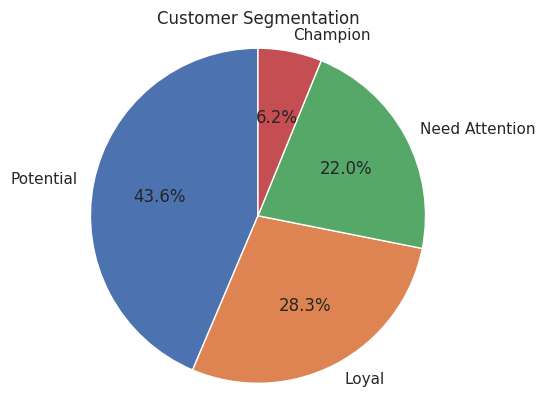

In [9]:
PieChart('RFM_SEGMENT')

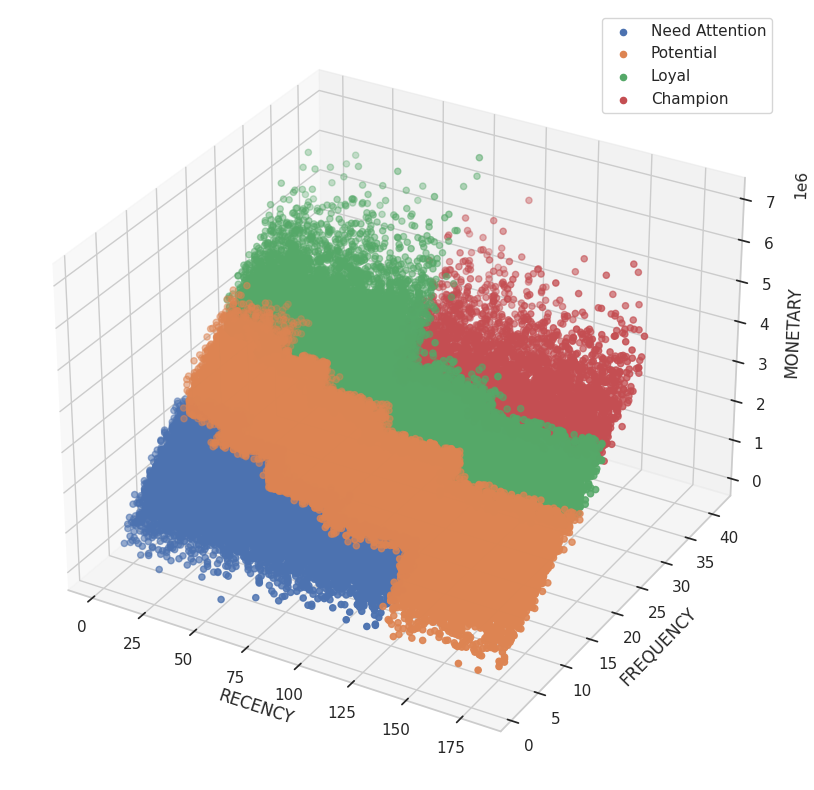

In [10]:
Chart3D ('RFM_SEGMENT')

In [11]:
SummaryStats('RFM_SEGMENT')

Segment_Need Attention  Segment_Potential  Segment_Loyal  \
RECENCY   mean             4.513490e+01       7.703580e+01   7.785097e+01   
          std              3.353542e+01       5.272017e+01   4.820519e+01   
          min              1.000000e+00       1.000000e+00   1.000000e+00   
          max              1.240000e+02       1.800000e+02   1.800000e+02   
          count            1.433700e+04       2.846700e+04   1.843900e+04   
FREQUENCY mean             9.746600e+00       1.506105e+01   2.220771e+01   
          std              2.662445e+00       4.241680e+00   3.833519e+00   
          min              1.000000e+00       2.000000e+00   1.100000e+01   
          max              1.800000e+01       3.000000e+01   4.100000e+01   
          count            1.433700e+04       2.846700e+04   1.843900e+04   
MONETARY  mean             1.419003e+06       2.249794e+06   3.416531e+06   
          std              4.257437e+05       6.530865e+05   6.673905e+05   
          min              6.587782e+04       1.837732e+05   1.825676e+06   
          max              2.753417e+06       4.720380e+06   7.012696e+06   
          count            1.433700e+04       2.846700e+04   1.843900e+04   

                 Segment_Champion  
RECENCY   mean       1.284709e+02  
          std        2.738473e+01  
          min        8.300000e+01  
          max        1.800000e+02  
          count      4.020000e+03  
FREQUENCY mean       2.487587e+01  
          std        2.796804e+00  
          min        1.900000e+01  
          max        3.900000e+01  
          count      4.020000e+03  
MONETARY  mean       3.887328e+06  
          std        5.009808e+05  
          min        2.762626e+06  
          max        6.287149e+06  
          count      4.020000e+03

## Data Exploration

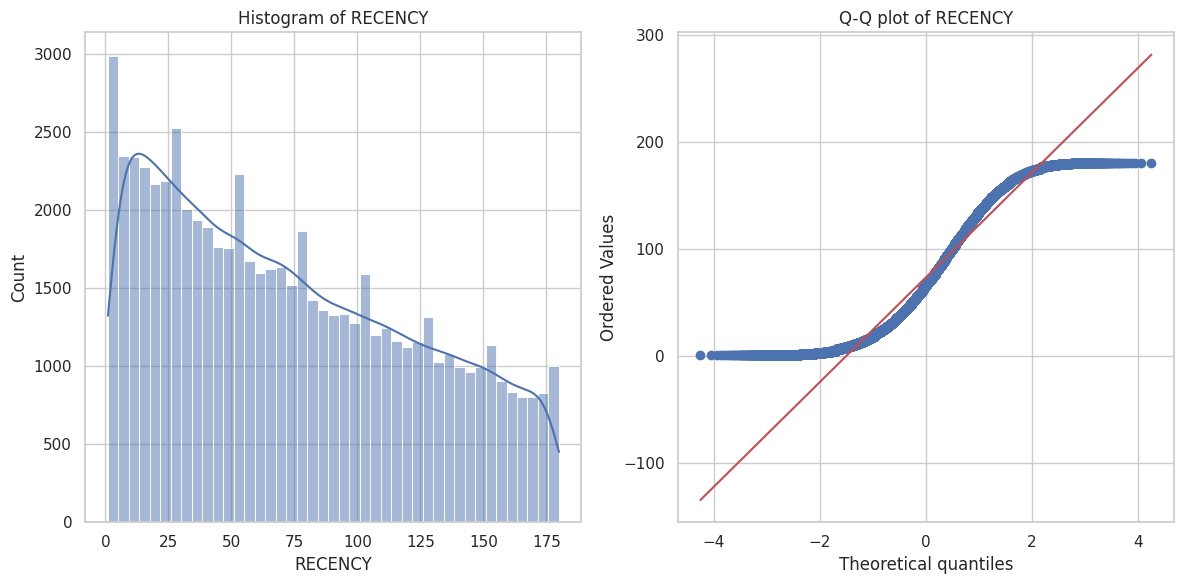

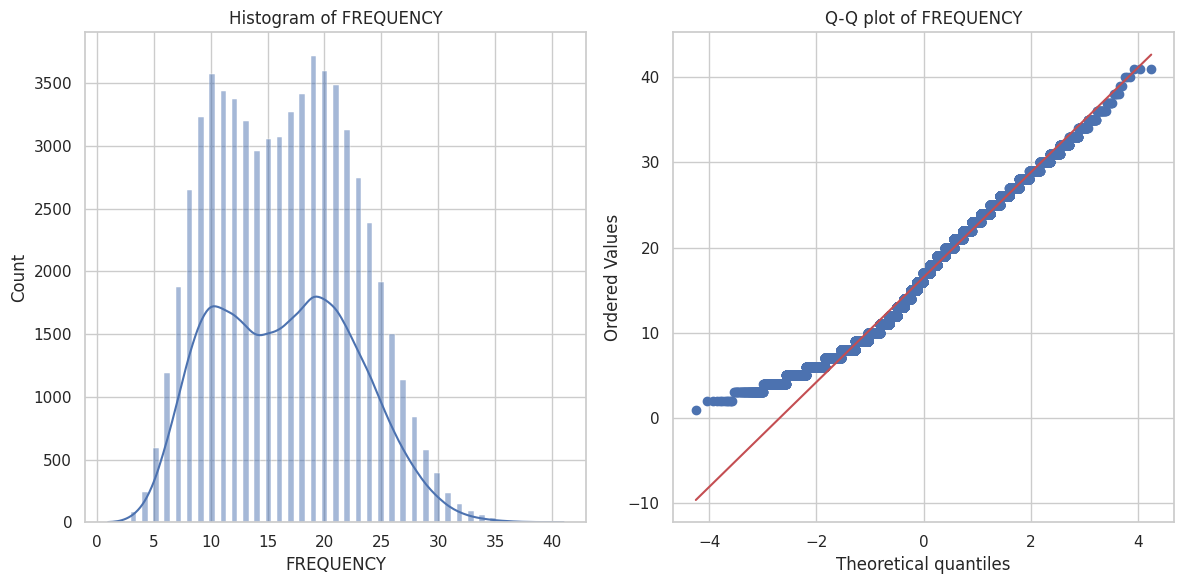

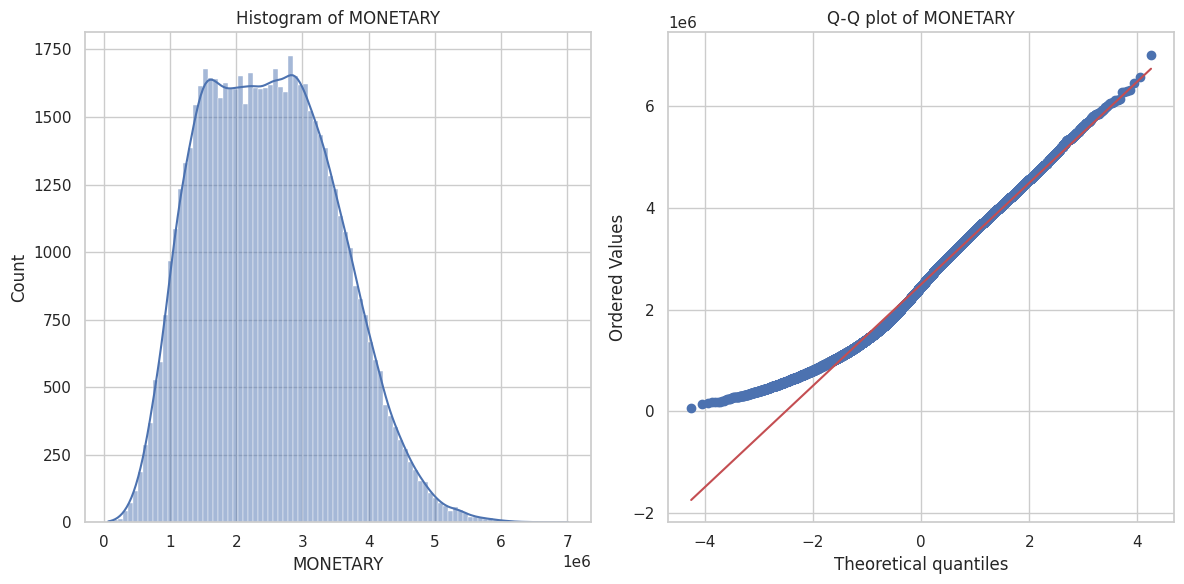

In [12]:
columns = df.shape[1]

# Check normality assumption for numerical values (no dummies)
for c in df[numerical_features].columns:
    data = df[c]

    # Visual Inspection: Histogram and Q-Q plot
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    sns.histplot(data, kde=True)
    plt.title(f'Histogram of {c}')

    plt.subplot(1, 2, 2)
    stats.probplot(data, dist="norm", plot=plt)
    plt.title(f'Q-Q plot of {c}')

    plt.tight_layout()
    plt.show()

With the exception of `Recency`, which is really a more discrete variable, `Frequency` and `Monetary` seems to have been normalized quite nicely. 
Well, allow some 'slack' here.

In [13]:
#Data preprocessing: scaling and normalization
class BoxCoxTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, alpha=0.05):
        self.alpha = alpha

    def fit(self, X, y=None):
        self.lambdas_ = {}
        self.shifts_ = {}
        for col in X.columns:
            # Shift data if necessary
            min_val = X[col].min()
            shift = 0 if min_val > 0 else -min_val + 1
            self.shifts_[col] = shift
            shifted_data = X[col] + shift

            # Apply Anderson-Darling test
            ad_test_result = anderson(shifted_data.dropna())
            if ad_test_result.statistic > ad_test_result.critical_values[0]:  # Comparing with the critical value at 15% significance level
                _, maxlog = boxcox(shifted_data.dropna())
                self.lambdas_[col] = maxlog
        return self

    def transform(self, X):
        X_transformed = pd.DataFrame(index=X.index)
        for col in X.columns:
            shifted_data = X[col] + self.shifts_.get(col, 0)
            if col in self.lambdas_:
                transformed_col = boxcox(shifted_data, lmbda=self.lambdas_[col])
                X_transformed[col] = transformed_col
            else:
                X_transformed[col] = shifted_data
        return X_transformed

In [14]:
# Create a pipeline for numerical features
numerical_pipeline = Pipeline([
    ('boxcox', BoxCoxTransformer()),
    ('scaler', StandardScaler())
])

In [15]:
# Create a column transformer to combine the pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_features)
    ],
    remainder='passthrough'
)

In [16]:
df_selected = df[numerical_features]

In [17]:
# Apply the transformations
transformed_data = preprocessor.fit_transform(df_selected)

In [18]:
# Create the final DataFrame
transformed_df = pd.DataFrame(transformed_data,index = df.index)

In [19]:
## Best Gaussian Model based on smallest AIC and BIC

In [20]:
def find_best_gmm(X, k_range=(2, 8)):
    best_aic = np.inf
    best_bic = np.inf
    best_k = None
    best_gmm = None
    aic_values = []
    bic_values = []

    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=0).fit(X)
        aic = gmm.aic(X)
        bic = gmm.bic(X)

        # Store the various AICs and BICs
        aic_values.append(aic)
        bic_values.append(bic)

        if aic < best_aic:
            best_aic = aic
            best_bic = bic
            best_k = k
            best_gmm = gmm

    return best_gmm, best_k, best_aic, best_bic, aic_values, bic_values

# Example usage
# Assuming 'transformed_df' is the DataFrame from the pipeline
k_range = range(3,12)
best_gmm_model, best_k, best_aic, best_bic, aics, bics = find_best_gmm(transformed_df, k_range)
print(f"Best GMM Model: {best_k} segments")
print(f"AIC: {best_aic}")
print(f"BIC: {best_bic}")

Best GMM Model: 9 segments
AIC: 404958.4472448992
BIC: 405767.1173128752


Text(0.5, 0, 'Number of Segments')

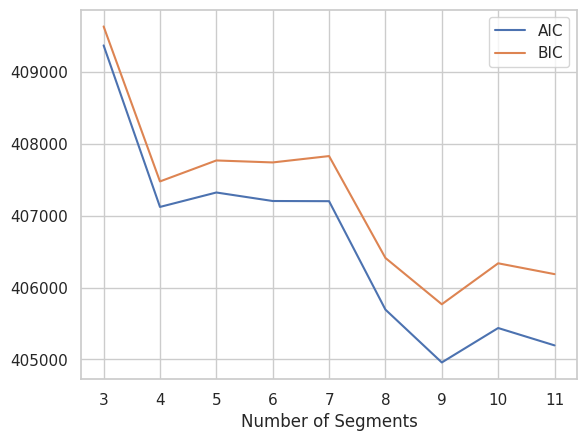

In [21]:
# Plotting AIC and BIC
plt.plot ([k for k in k_range], aics, label='AIC')
plt.plot ([k for k in k_range], bics, label='BIC')
plt.legend()
plt.xlabel('Number of Segments')

While the AIC and BIC continue to decrease as we increase the components, we are looking to the simplest (less complex) model - 4 segments.

In [22]:
# Let's build the model with 4 components
gmm = GaussianMixture(n_components=4, random_state=42).fit(transformed_df)

# Assigning the segments to the original DataFrame
df['GMM_SEGMENT'] = gmm.predict(transformed_df)

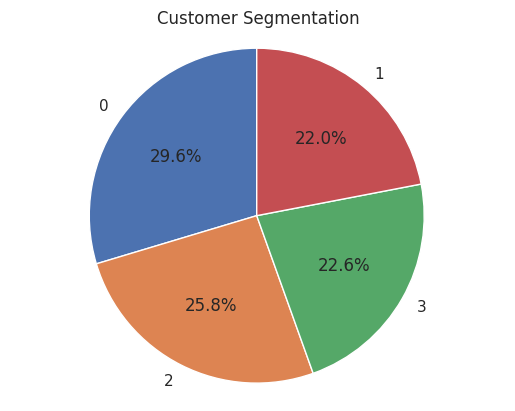

In [23]:
PieChart('GMM_SEGMENT')

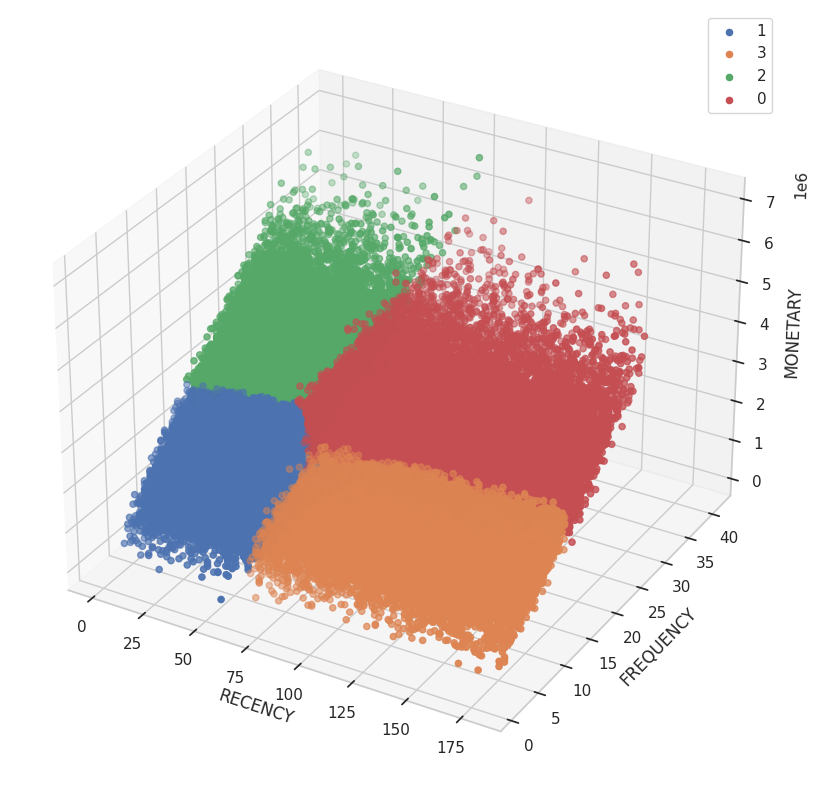

In [24]:
Chart3D ('GMM_SEGMENT')

In [25]:
SummaryStats('GMM_SEGMENT')

Segment_1     Segment_3     Segment_2     Segment_0
RECENCY   mean   3.217681e+01  1.205825e+02  2.702587e+01  1.085573e+02
          std    1.879157e+01  3.318278e+01  1.715558e+01  3.369021e+01
          min    1.000000e+00  6.100000e+01  1.000000e+00  5.200000e+01
          max    7.400000e+01  1.800000e+02  8.000000e+01  1.800000e+02
          count  1.434300e+04  1.471800e+04  1.685500e+04  1.934700e+04
FREQUENCY mean   1.146134e+01  1.008717e+01  2.208662e+01  2.030527e+01
          std    2.927949e+00  2.590473e+00  3.804165e+00  3.739385e+00
          min    1.000000e+00  2.000000e+00  1.400000e+01  1.300000e+01
          max    1.700000e+01  1.500000e+01  4.100000e+01  3.900000e+01
          count  1.434300e+04  1.471800e+04  1.685500e+04  1.934700e+04
MONETARY  mean   1.723890e+06  1.522896e+06  3.352241e+06  3.068789e+06
          std    5.152610e+05  4.709306e+05  7.118997e+05  6.789368e+05
          min    6.587782e+04  1.837732e+05  1.098385e+06  1.142495e+06
          max    3.250354e+06  2.956123e+06  7.012696e+06  6.287149e+06
          count  1.434300e+04  1.471800e+04  1.685500e+04  1.934700e+04

## KMeans Clustering

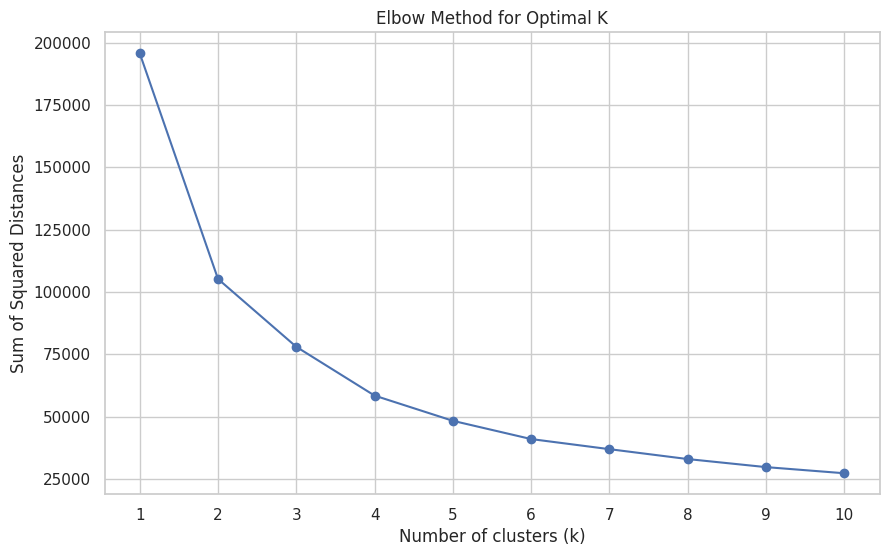

In [26]:
def find_optimal_k(df, max_k):
    """
    Apply the elbow method to find the optimal number of clusters (k) for KMeans clustering.

    Parameters:
    df (DataFrame): The dataframe containing the data to cluster.
    max_k (int): The maximum number of clusters to try.

    Returns:
    None: This function plots a graph showing the elbow curve.
    """
    ssd = []  # Sum of squared distances

    for k in range(1, max_k + 1):
        kmeans = KMeans(n_clusters=k, n_init=42, random_state=42)
        kmeans.fit(df)
        ssd.append(kmeans.inertia_)

    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_k + 1), ssd, marker='o')
    plt.title('Elbow Method for Optimal K')
    plt.xlabel('Number of clusters (k)')
    plt.ylabel('Sum of Squared Distances')
    plt.xticks(range(1, max_k + 1))
    plt.grid(True)
    plt.show()

find_optimal_k(transformed_df, 10)

For n_clusters = 2 The average silhouette_score is : 0.39456184799860006
For n_clusters = 3 The average silhouette_score is : 0.35324598738267426
For n_clusters = 4 The average silhouette_score is : 0.3454566132791468
For n_clusters = 5 The average silhouette_score is : 0.3288985376655297
For n_clusters = 6 The average silhouette_score is : 0.3159121346635683
For n_clusters = 7 The average silhouette_score is : 0.30676213103112726
For n_clusters = 8 The average silhouette_score is : 0.31091243614994263
For n_clusters = 9 The average silhouette_score is : 0.3006238474487395


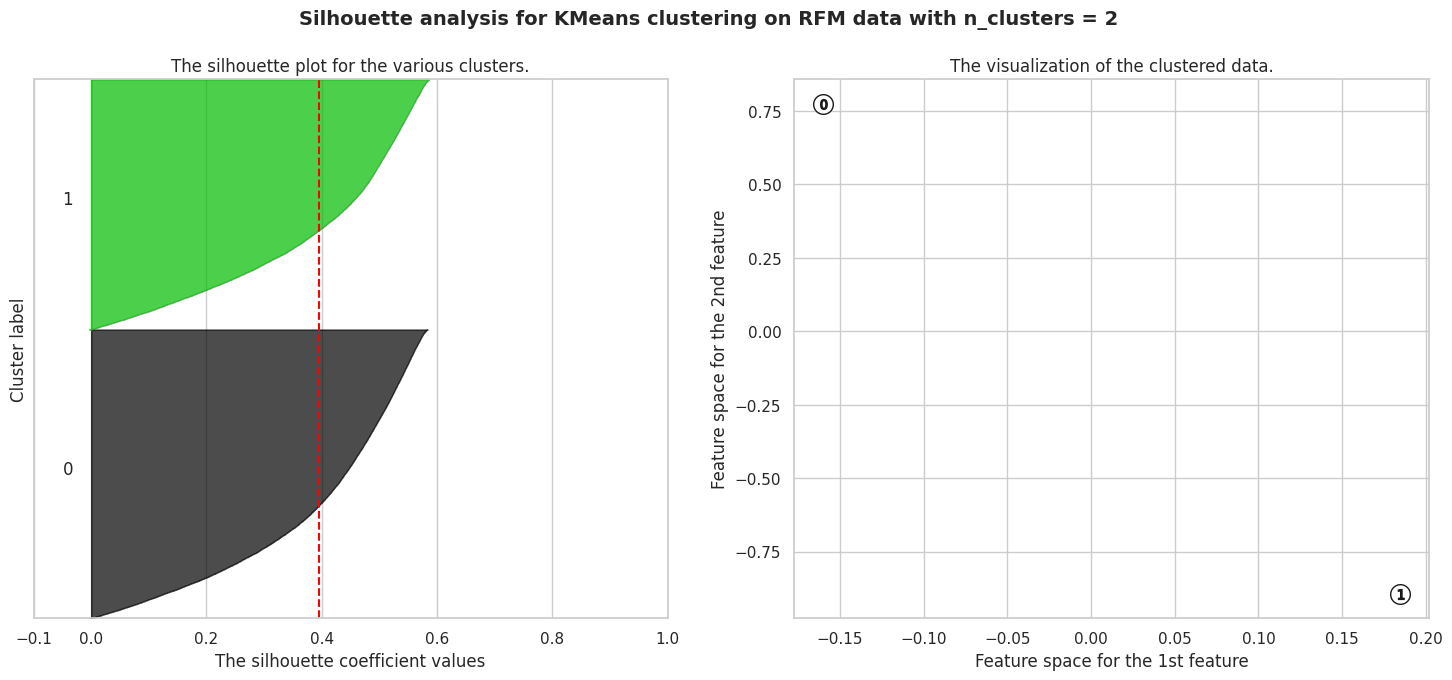

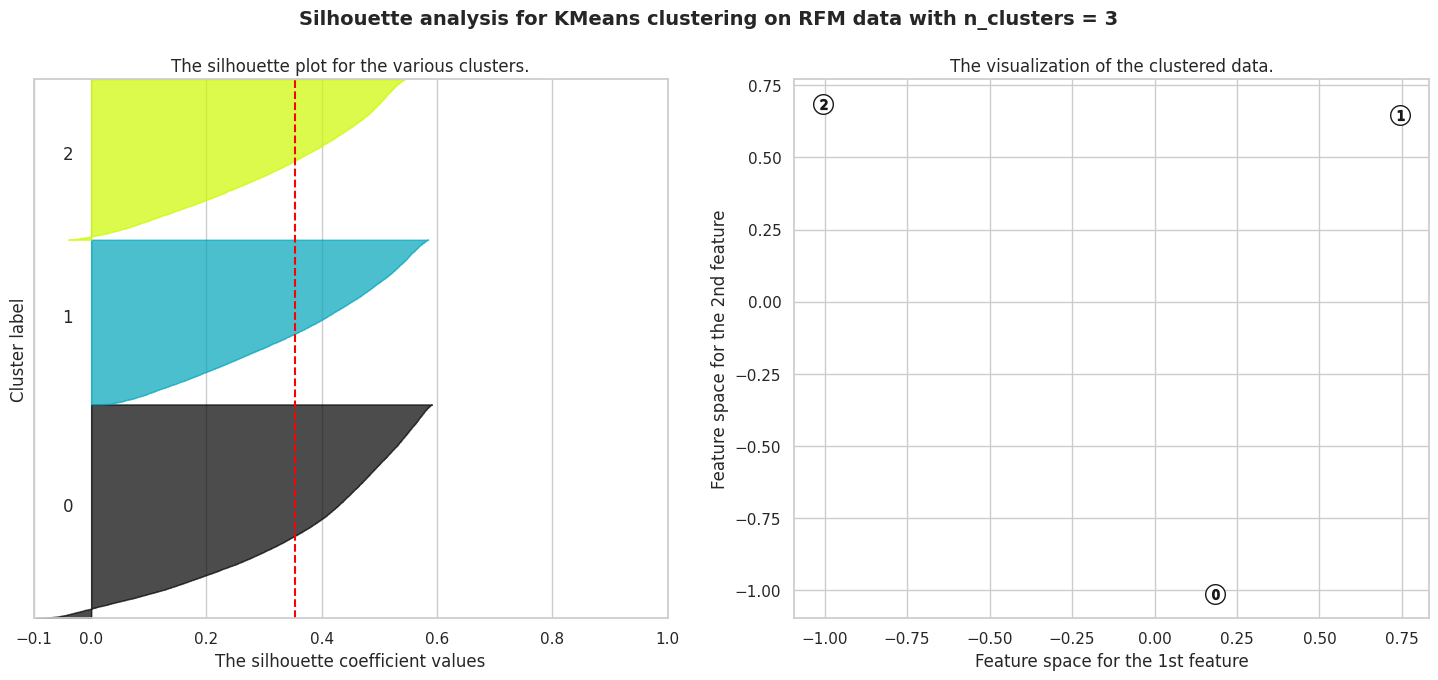

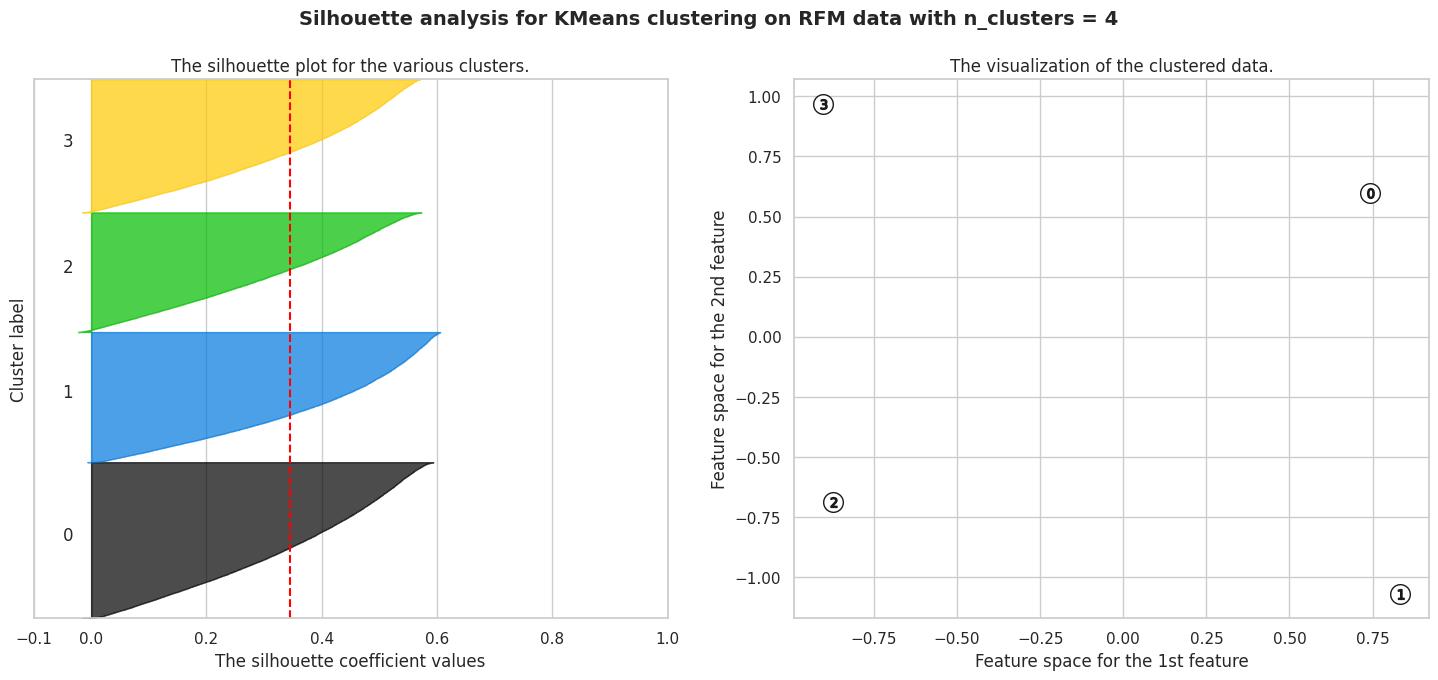

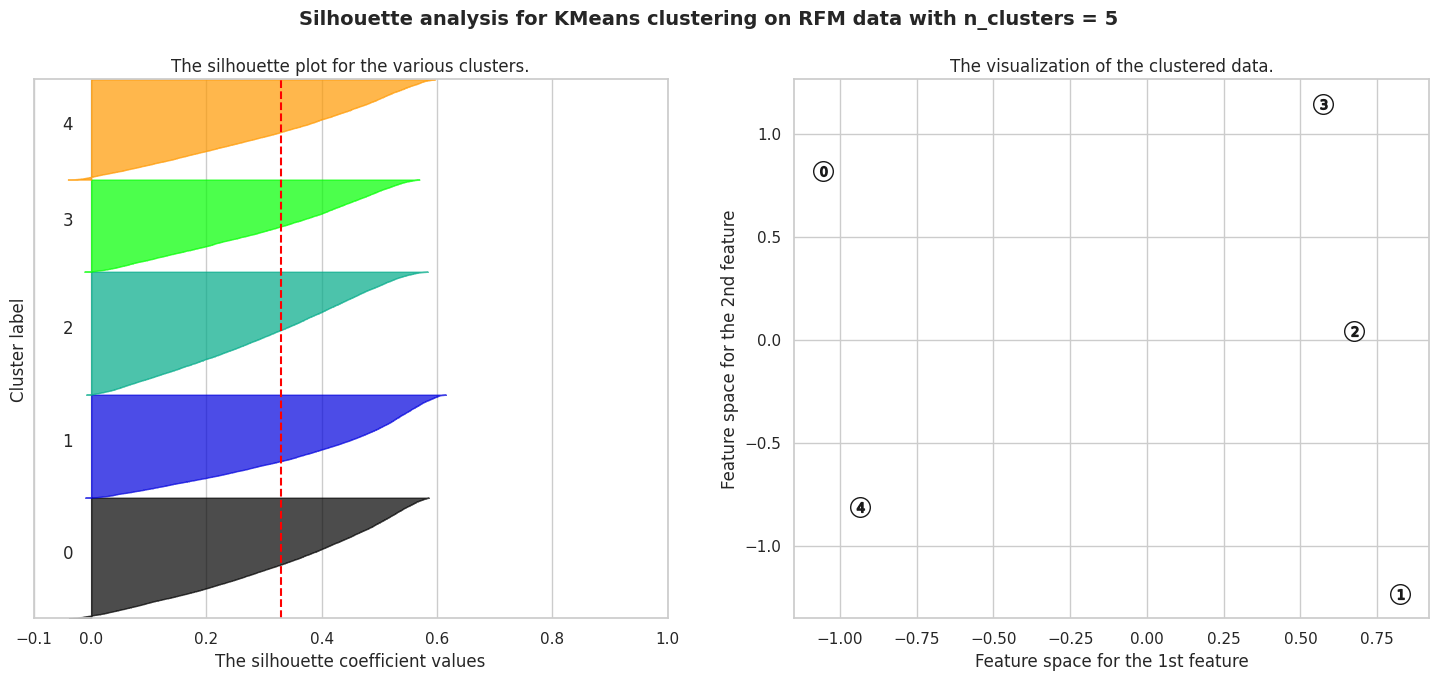

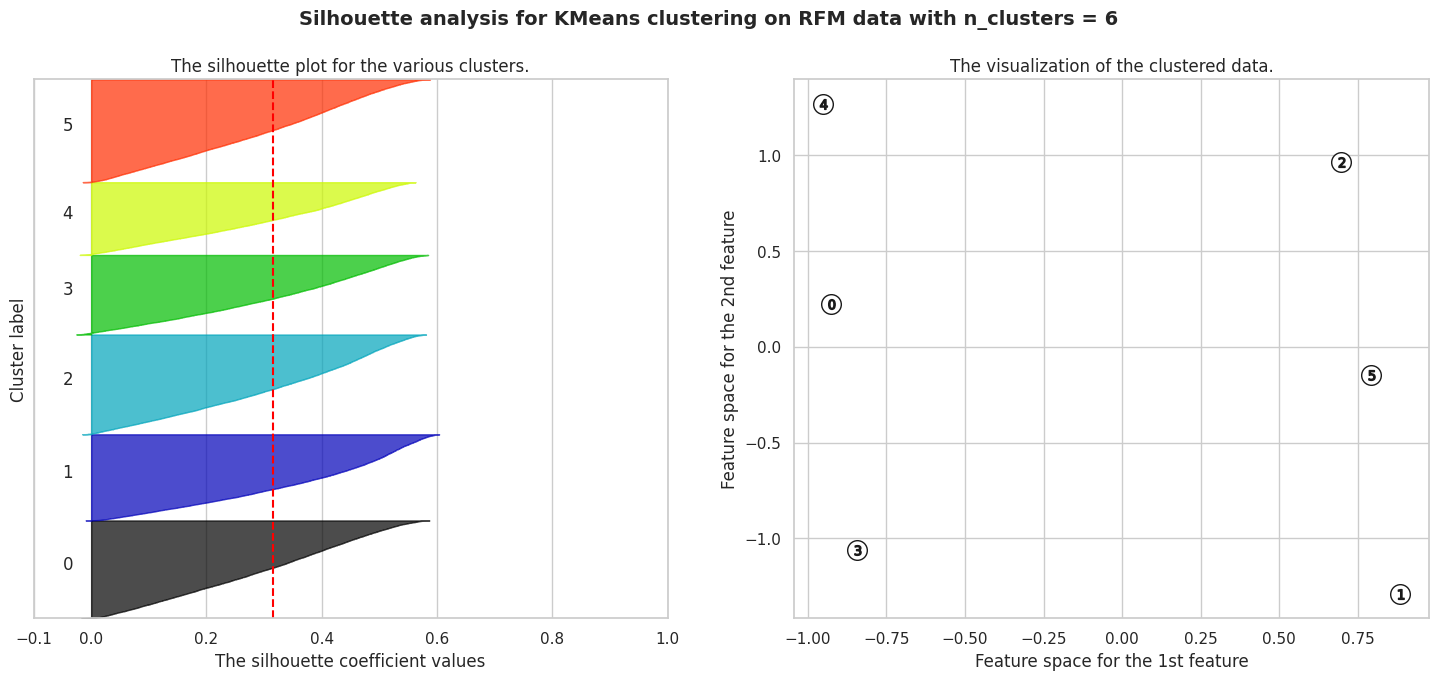

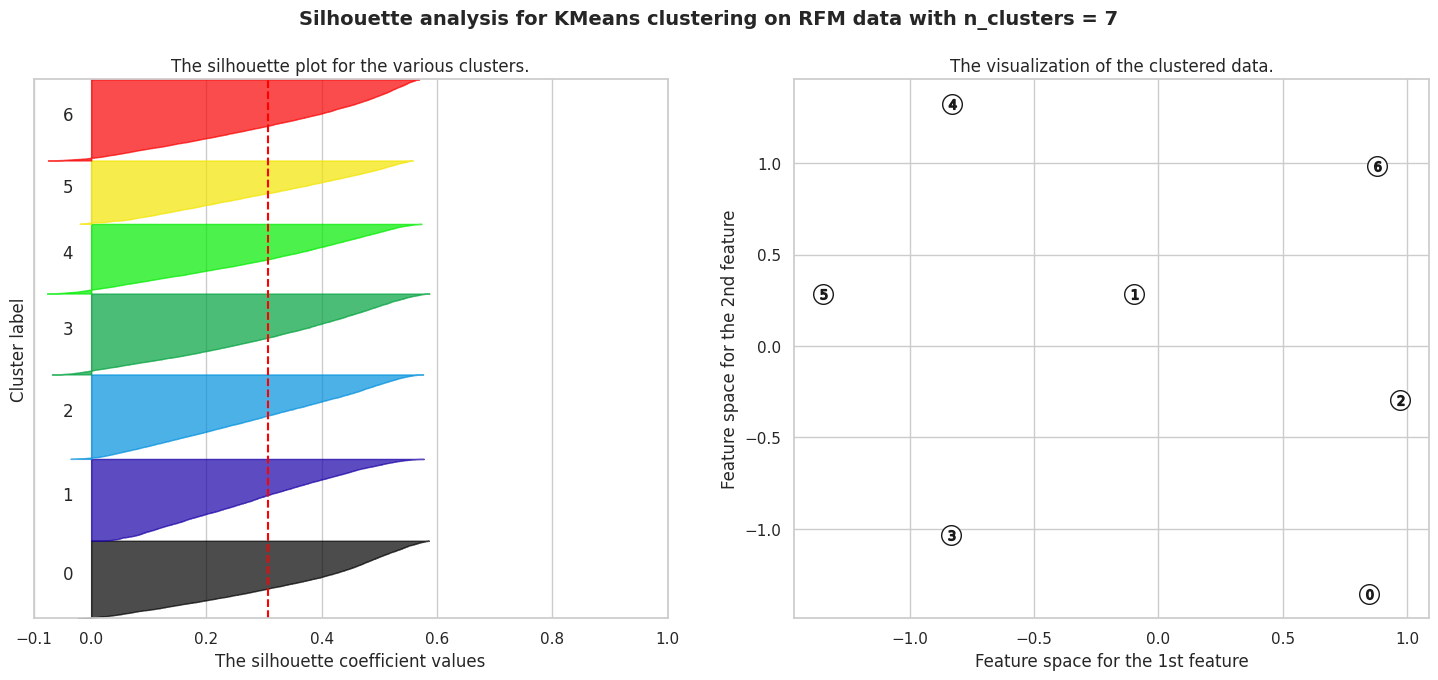

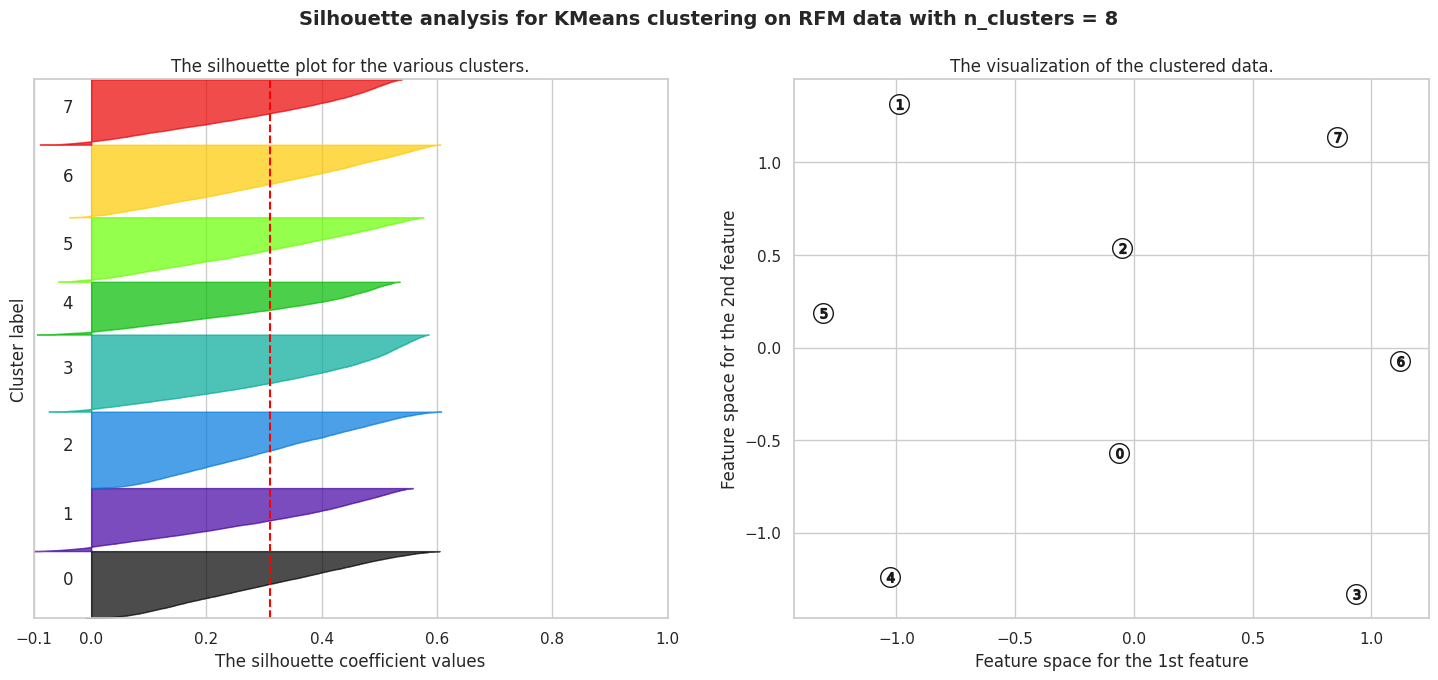

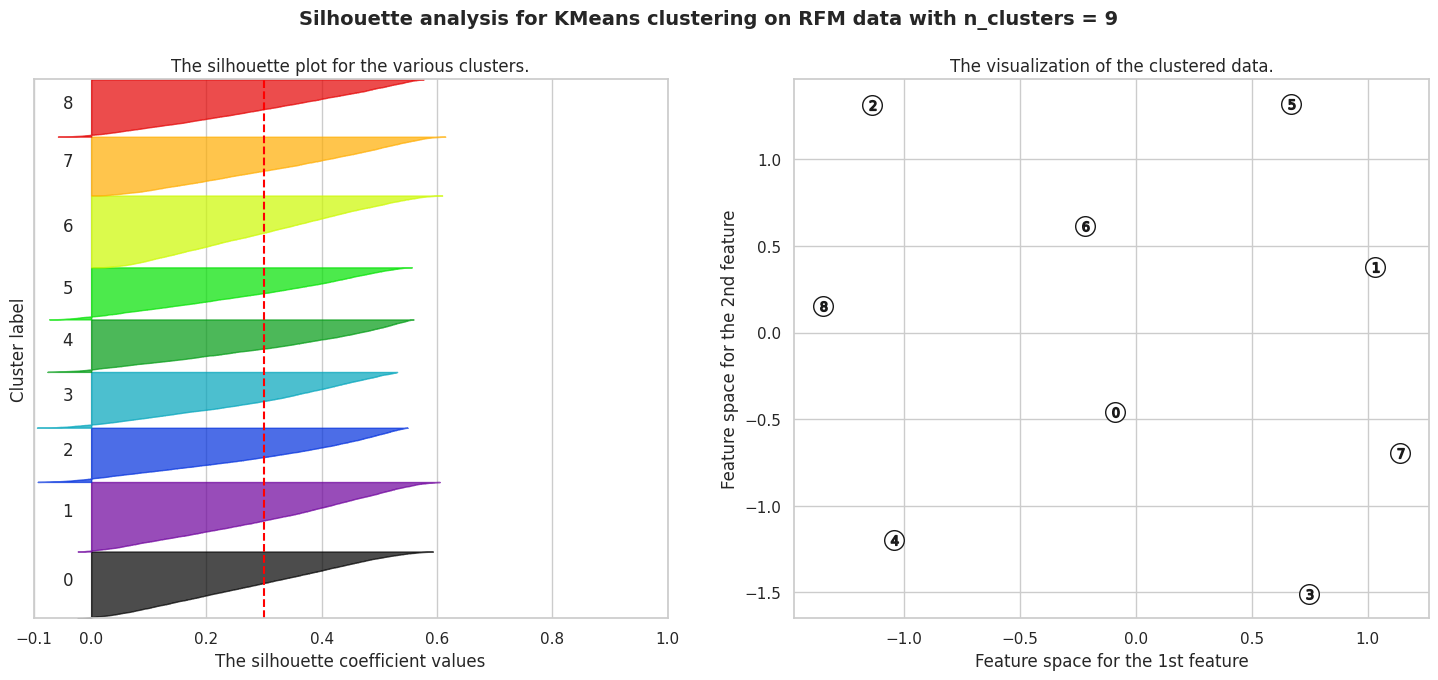

In [27]:
##########################################################################
## CREDIT:
##    This code has been adapted from
##    https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
##########################################################################
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9]
s_avg = []

for n_clusters in range_n_clusters:
    # Data to train the cluster model
    X = transformed_df.to_numpy()

    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init='k-means++', n_init=42, random_state=42)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    s_avg.append(silhouette_avg)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    #ax2.scatter(space_2d[..., 0], space_2d[..., 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on RFM data "
                  "with n_clusters = %d" % n_clusters), fontsize=14, fontweight='bold')

plt.show()

In [28]:
# Let's build the model with 4 components
kmeans = KMeans(n_clusters=4, init='random', max_iter=100, n_init=42, random_state = 42).fit(transformed_df)

# Assigning the segments to the original DataFrame
df['KMEANS_SEGMENT'] = kmeans.predict(transformed_df)

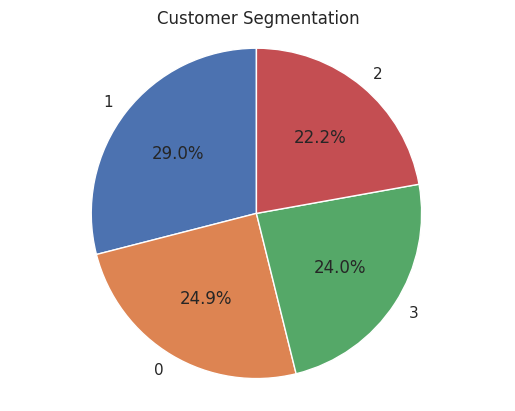

In [29]:
PieChart('KMEANS_SEGMENT')

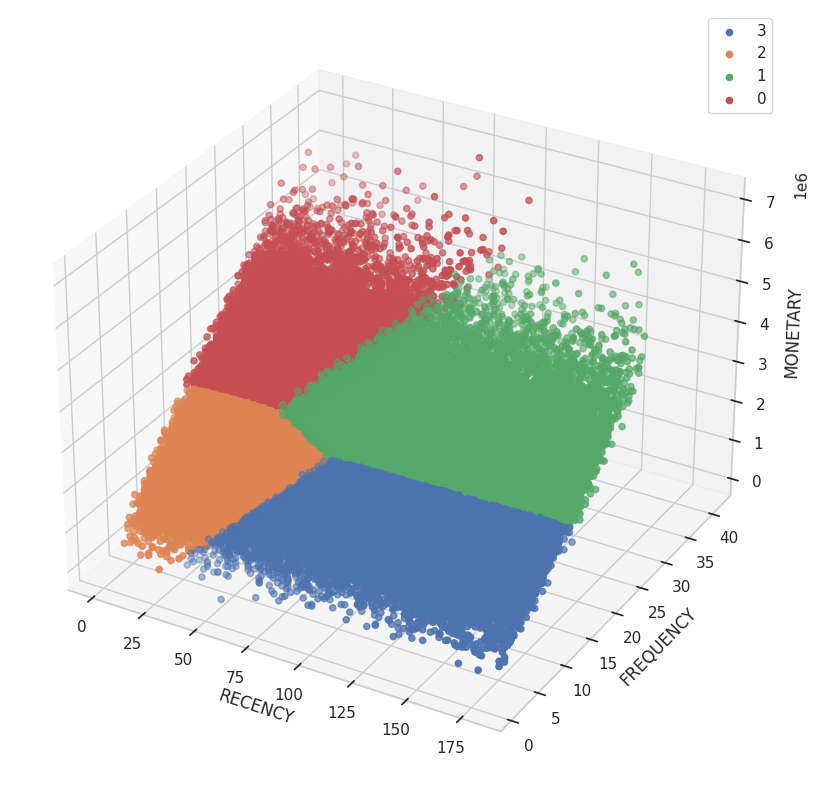

In [30]:
Chart3D ('KMEANS_SEGMENT')

In [31]:
SummaryStats('KMEANS_SEGMENT')

Segment_3     Segment_2     Segment_1     Segment_0
RECENCY   mean   1.160340e+02  2.987348e+01  1.096576e+02  2.893491e+01
          std    3.534958e+01  1.849191e+01  3.441101e+01  1.887904e+01
          min    3.300000e+01  1.000000e+00  4.700000e+01  1.000000e+00
          max    1.800000e+02  7.600000e+01  1.800000e+02  1.040000e+02
          count  1.563900e+04  1.447200e+04  1.892800e+04  1.622400e+04
FREQUENCY mean   1.001848e+01  1.209432e+01  2.005421e+01  2.260078e+01
          std    2.692014e+00  3.092478e+00  3.622855e+00  3.771401e+00
          min    1.000000e+00  2.000000e+00  1.100000e+01  1.400000e+01
          max    1.800000e+01  2.000000e+01  3.600000e+01  4.100000e+01
          count  1.563900e+04  1.447200e+04  1.892800e+04  1.622400e+04
MONETARY  mean   1.476618e+06  1.785757e+06  3.051995e+06  3.470732e+06
          std    4.408121e+05  4.842688e+05  6.142431e+05  6.723000e+05
          min    6.587782e+04  1.462517e+05  1.686218e+06  1.990789e+06
          max    2.698940e+06  3.149719e+06  5.967477e+06  7.012696e+06
          count  1.563900e+04  1.447200e+04  1.892800e+04  1.622400e+04

In [32]:
df.groupby(['RFM_SEGMENT','GMM_SEGMENT']).size()

RFM_SEGMENT     GMM_SEGMENT
Champion        0               4020
Loyal           0              10442
                2               7844
                3                153
Need Attention  0                 10
                1              10054
                2                213
                3               4060
Potential       0               4875
                1               4289
                2               8798
                3              10505
dtype: int64

In [33]:
df.groupby(['RFM_SEGMENT','KMEANS_SEGMENT']).size()

RFM_SEGMENT     KMEANS_SEGMENT
Champion        0                    67
                1                  3953
Loyal           0                  8363
                1                 10061
                3                    15
Need Attention  2                  9389
                3                  4948
Potential       0                  7794
                1                  4914
                2                  5083
                3                 10676
dtype: int64

In [34]:
df.groupby(['GMM_SEGMENT','KMEANS_SEGMENT']).size()

GMM_SEGMENT  KMEANS_SEGMENT
0            0                   658
             1                 17944
             2                   227
             3                   518
1            0                   114
             1                   167
             2                 13083
             3                   979
2            0                 15452
             1                   290
             2                  1113
3            1                   527
             2                    49
             3                 14142
dtype: int64

In [35]:
df.groupby(['KMEANS_SEGMENT','GMM_SEGMENT']).size()

KMEANS_SEGMENT  GMM_SEGMENT
0               0                658
                1                114
                2              15452
1               0              17944
                1                167
                2                290
                3                527
2               0                227
                1              13083
                2               1113
                3                 49
3               0                518
                1                979
                3              14142
dtype: int64

KMeans and Gaussian creates very similar clusters - almost the same by size.

GMM Segments:
- Segment 2 - Recent, frequent and spent more money (Champions)
- Segment 0 - Purchace long time ago , frequent and spent more money (Used to be Loyal, but Need more attention)
- Segment 1 - Recent, rare and spent less money (Potential)
- Segment 3 - Purchace long time ago , rare and spent less money (Potential)

KMeans Segments:
- Segment 0 - Recent, frequent and spent more money (Champions)
- Segment 1 - Purchace long time ago , frequent and spent more money (Used to be Loyal, but Need more attention)
- Segment 2 - Recent, rare and spent less money (Potential)
- Segment 3 - Purchace long time ago , rare and spent less money (Potential)